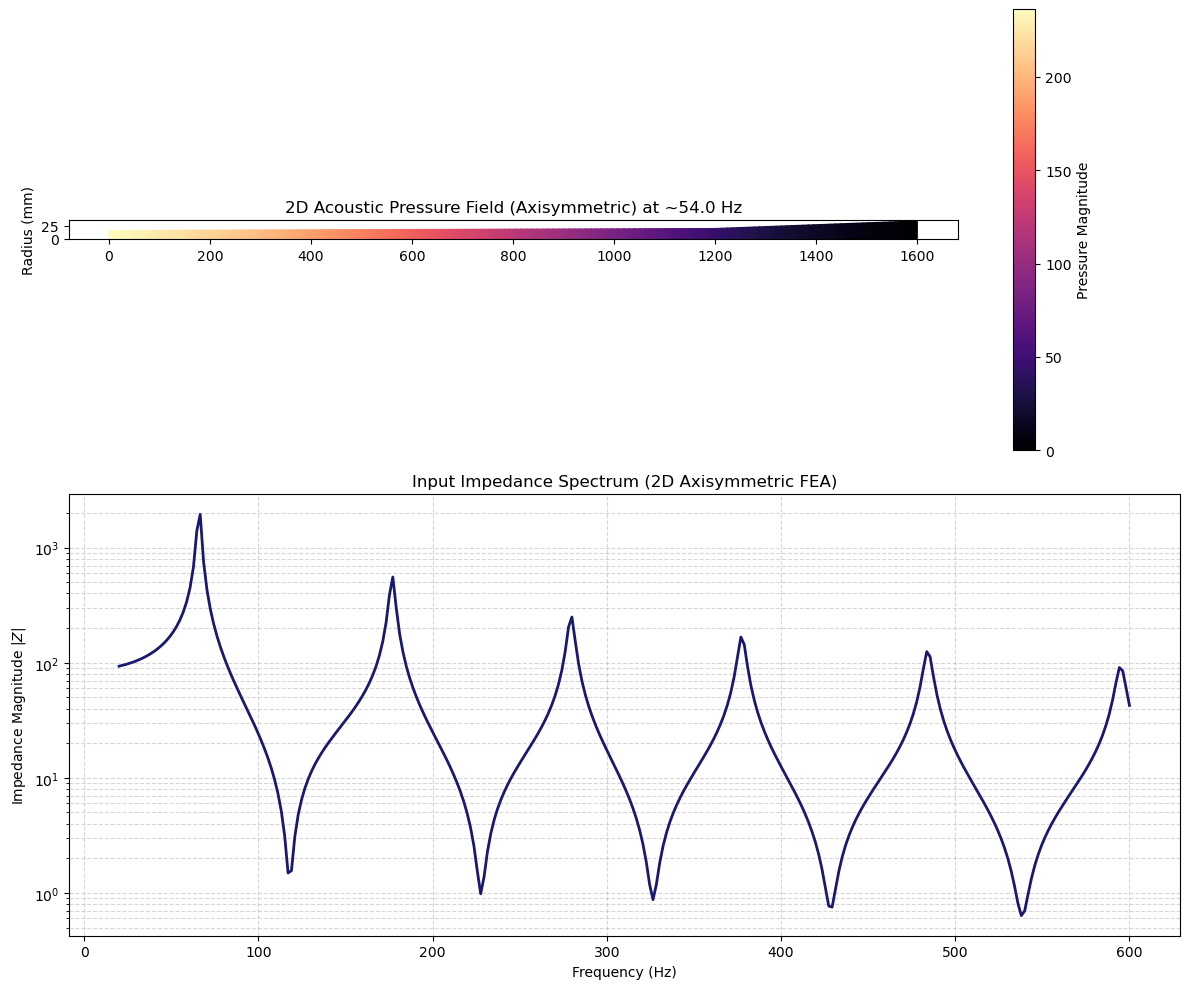

In [25]:
import numpy as np
import skfem as fem
from skfem.helpers import dot, grad
import matplotlib.pyplot as plt

# 1. Geometry and Constants
segments = np.array([[0, 32], [1200, 40], [1600, 70]])  # mm
c = 343000.0  # mm/s
frequencies = np.linspace(20, 600, 300)

x_coords = segments[:, 0]
diameters = segments[:, 1]

# 2. Build 2D Mesh (Half-profile)
n_z, n_r = 150, 10
mesh = fem.MeshTri.init_tensor(
    np.linspace(0, x_coords[-1], n_z),
    np.linspace(0, 1, n_r)
)

def get_radius(z):
    return np.interp(z, x_coords, diameters) / 2.0

mesh.p[1, :] *= get_radius(mesh.p[0, :])
basis = fem.Basis(mesh, fem.ElementTriP1())

# 3. Define Axisymmetric Forms
def stiffness_fun(u, v, w):
    return w.x[1] * dot(grad(u), grad(v))

def mass_fun(u, v, w):
    return w.x[1] * u * v

K = fem.BilinearForm(stiffness_fun).assemble(basis)
M = fem.BilinearForm(mass_fun).assemble(basis)

# 4. Boundary and Source Handling
# Bell end (Open): Pressure = 0
bell_data = basis.get_dofs(lambda x: np.isclose(x[0], x_coords[-1])).nodal
bell_indices = np.concatenate([list(v) for v in bell_data.values()]) if isinstance(bell_data, dict) else bell_data

# Mouthpiece: Manual Load Injection
# We create a vector of zeros and put '1' at the mouthpiece nodes
b_mouth = np.zeros(basis.N)
mouth_data = basis.get_dofs(lambda x: np.isclose(x[0], 0)).nodal
mouth_indices = np.concatenate([list(v) for v in mouth_data.values()]).astype(int) if isinstance(mouth_data, dict) else mouth_data.astype(int)

# Injecting 1.0 into the mouthpiece DOFs acts as our volume velocity source
b_mouth[mouth_indices] = 1.0 

# 5. Frequency Sweep
impedance_spectrum = []
p_visual = None
target_f = 54.0

for f in frequencies:
    omega = 2 * np.pi * f
    # Add light damping to prevent infinite spikes and zeros
    k = (omega / c) - 1j * (2e-6 * np.sqrt(f))
    A = K - (k**2) * M
    
    # Solve for complex pressure p
    p = fem.solve(*fem.condense(A, b_mouth, D=bell_indices))
    
    # Magnitude of pressure averaged over the mouthpiece
    p_mag = np.abs(p)
    impedance_spectrum.append(np.mean(p_mag[mouth_indices]))
    
    if np.abs(f - target_f) < (frequencies[1] - frequencies[0]):
        p_visual = p_mag

# 6. Visualization
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Plot 1: Pressure field at resonance
if p_visual is not None:
    tpc = ax1.tripcolor(mesh.p[0], mesh.p[1], mesh.t.T, p_visual, 
                        cmap='magma', shading='gouraud')
    fig.colorbar(tpc, ax=ax1, label='Pressure Magnitude')



ax1.set_title(f"2D Acoustic Pressure Field (Axisymmetric) at ~{target_f} Hz")
ax1.set_ylabel("Radius (mm)")
ax1.set_aspect('equal')

# Plot 2: Impedance Spectrum
ax2.semilogy(frequencies, impedance_spectrum, color='midnightblue', lw=2)
ax2.set_title("Input Impedance Spectrum (2D Axisymmetric FEA)")
ax2.set_xlabel("Frequency (Hz)")
ax2.set_ylabel("Impedance Magnitude $|Z|$")
ax2.grid(True, which='both', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

In [12]:
import scipy
i = scipy.signal.find_peaks(impedance_spectrum)
frequencies[i[0]]


array([ 66.55518395, 177.12374582, 279.93311037, 376.92307692,
       483.61204013, 594.18060201])

,note_name,cent_diff,note_nr,freq,impedance,rel_imp
0,C2,-12.631656,-33,64.930901,23.998926,1.000000
1,F3,-7.631656,-16,173.846073,6.640184,0.276687
2,C#4,-27.631656,-8,272.793728,1.906460,0.079439
3,F#4,-7.631656,-3,368.366996,1.282197,0.053427
4,A#4,22.368344,1,472.225891,1.095542,0.045650
5,D5,-27.631656,5,578.029775,0.704364,0.029350
6,E5,-12.631656,7,654.462476,0.630788,0.026284
7,F#5,37.368344,9,756.134987,0.901504,0.037564
8,A5,-32.631656,12,863.568414,1.007926,0.041999
9,B5,-37.631656,14,966.527296,1.088289,0.045347


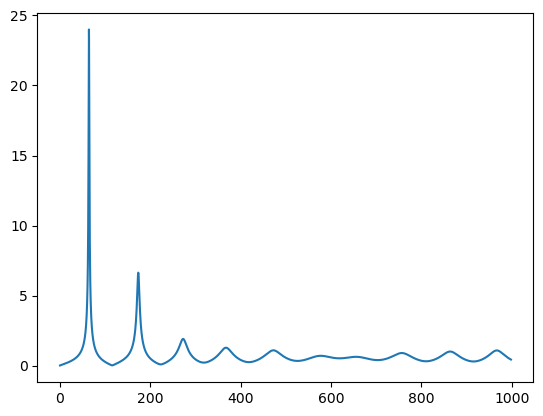

In [14]:
import sys
sys.path.append("../../")

from didgelab.calc.sim.sim import compute_impedance_iteratively, get_notes, compute_impedance, create_segments, get_log_simulation_frequencies
from didgelab.calc.geo import Geo, geotools

geo = [[0, 32], [1200, 40], [1600, 70]]
geo = Geo(geo)
freqs = get_log_simulation_frequencies(1, 1000, 5)
segments = create_segments(geo)
impedances = compute_impedance(segments, freqs)
notes = get_notes(freqs, impedances)
plt.plot(freqs, impedances)
notes
